# MC Dropout
https://github.com/yaringal/DropoutUncertaintyExps/blob/master/net/net.py

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

keras = tf.keras
tfd = tfp.distributions

print("Tensorflow Version: %s" % tf.__version__)
print("Tensorflow Probability Version: %s" % tfp.__version__)

C:\Users\Tom\Anaconda3\envs\mltf2\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


Tensorflow Version: 2.0.0-beta0
Tensorflow Probability Version: 0.8.0-dev20190610


In [2]:
# commons package
import os
import sys
import importlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import commons as cm
importlib.reload(cm)

<module 'commons' from 'D:\\Tom\\Documents\\gitworkspace\\master\\ml-probability\\tfp_word_embeddings\\commons.py'>

# Configuration and Parameters

In [3]:
# GloVe Configuration

# Directory containing the GloVe files.
GLOVE_DIR = "D:/google drive/haw/master/mastertheisis/hauptprojekt"

# Embedding dimension
EMBEDDING_DIM = 50

In [4]:
imdb = cm.load_imdb()
(x_train, y_train), (x_test, y_test) = imdb

In [5]:
# MC Dropout parameters

# model save file
model_save_file = "./models/mc_dropout.h5"

# number of data points
N = x_train.shape[0]

# hidden layers where each element denotes the nummer of neurons
n_hidden = [128, 128]

# batch size for training
batch_size = 128

# training epochs 
epochs = 6

# prior lenght scale
lengthscale = 1e-2

# dropout rate for all dropout layers in the network, 1. means drop all
dropout = 0.5

# model precision used for regularization
tau = 1.0

# regularization
reg = lengthscale**2 * (1 - dropout) / (2. * N * tau)

# MCMC Samples
T = 50

# GloVe Word Embedding

In [6]:
# GLOVE Word Embedding
word_index = cm.WordIndex()
embedding_index = cm.load_glove_embedding(GLOVE_DIR, EMBEDDING_DIM)
(embedding_matrix, unknown_words) = word_index.match_glove(embedding_index=embedding_index, embedding_dim=EMBEDDING_DIM)
max_length = cm.get_max_length(x_train, x_test)

Found 400000 word vectors.
17361/88587 unknown words


In [7]:
# pad input vectors
x_train_padded = cm.pad_input(x_train, max_length)
x_test_padded = cm.pad_input(x_test, max_length)

# Model

In [8]:
def create_model():
    inputs = keras.Input(shape=(x_train_padded.shape[1],), dtype='int32')

    # embedding layer
    embedding_layer = keras.layers.Embedding(len(word_index.index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=max_length,
                                trainable=False)
    inter = embedding_layer(inputs)

    for i in range(len(n_hidden)):
        inter = keras.layers.Dropout(dropout)(inter, training=True)
        inter = keras.layers.Dense(n_hidden[i], activation='relu', kernel_regularizer=keras.regularizers.l2(reg))(inter)

    inter = keras.layers.Dropout(dropout)(inter, training=True)
    inter = keras.layers.Flatten()(inter)
    outputs = keras.layers.Dense(1, kernel_regularizer=keras.regularizers.l2(reg), activation="sigmoid")(inter)
    model = keras.Model(inputs, outputs)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model

try:
    model = keras.models.load_model(model_save_file)
    print("using saved model weights")
except:
    model = create_model()
    print("model has not been trained")

model.summary()

model has not been trained
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2697)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2697, 50)          4429400   
_________________________________________________________________
dropout (Dropout)            (None, 2697, 50)          0         
_________________________________________________________________
dense (Dense)                (None, 2697, 128)         6528      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2697, 128)         0         
_________________________________________________________________
dense_1 (Dense)              (None, 2697, 128)         16512     
_________________________________________________________________
dropout_2 (Dropout)          (None

In [9]:
# keras callbacks
tb_callback = keras.callbacks.TensorBoard(log_dir='logs') 
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(model_save_file, 
                                                      monitor='val_loss', 
                                                      verbose=1, 
                                                      save_best_only=True, 
                                                      save_weights_only=False, 
                                                      mode='auto')

model.fit(x_train_padded, y_train, validation_split=0.05, epochs=epochs, batch_size=batch_size, callbacks=[tb_callback, model_checkpoint_cb])
loss, accuracy = model.evaluate(x_train_padded, y_train)

W0612 20:30:36.925418 11208 deprecation.py:323] From C:\Users\Tom\Anaconda3\envs\mltf2\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


training model
Train on 23750 samples, validate on 1250 samples
Epoch 1/6
23680/23750 [============================>.] - ETA: 0s - loss: 0.7183 - acc: 0.5500
Epoch 00001: val_loss improved from inf to 0.62023, saving model to ./models/mc_dropout.h5
23750/23750 [==============================] - 24s 990us/sample - loss: 0.7181 - acc: 0.5501 - val_loss: 0.6202 - val_acc: 0.6648
Epoch 2/6
23680/23750 [============================>.] - ETA: 0s - loss: 0.5844 - acc: 0.6974
Epoch 00002: val_loss improved from 0.62023 to 0.56046, saving model to ./models/mc_dropout.h5
23750/23750 [==============================] - 22s 941us/sample - loss: 0.5846 - acc: 0.6972 - val_loss: 0.5605 - val_acc: 0.7152
Epoch 3/6
23680/23750 [============================>.] - ETA: 0s - loss: 0.5417 - acc: 0.7353
Epoch 00003: val_loss improved from 0.56046 to 0.54729, saving model to ./models/mc_dropout.h5
23750/23750 [==============================] - 22s 934us/sample - loss: 0.5417 - acc: 0.7353 - val_loss: 0.5473 -

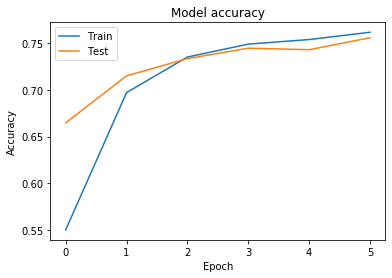

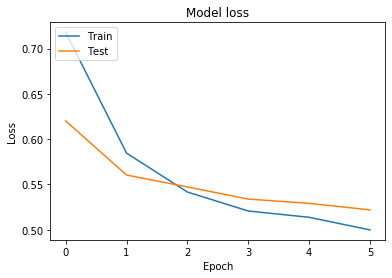

In [12]:
history = model.history

if history:
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [47]:
def sample_model(x, samples=150):
    preds = []
    for i in range(samples):
        pred = tf.squeeze(model.predict(tf.expand_dims(x, 0)))
        preds += [pred]

    plt.hist(preds, bins=20, range=(0, 1))
    plt.show()

    print("std: %f, mean: %f" % (tfp.stats.stddev(preds), tf.math.reduce_mean(preds)))

<START> please give this one a miss br br kristy swanson <UNK> <START> rest of <START> cast rendered terrible performances <START> show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out <UNK> his performance was quite lacklustre so all you madison fans give this a miss


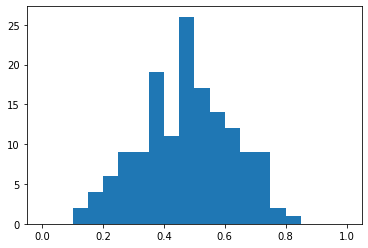

std: 0.150089, mean: 0.474955



<START> this film requires a lot of patience because it focuses on mood <UNK> character development <START> plot is very simple <UNK> many of <START> scenes take place on <START> same set in frances austen's <START> sandy dennis character apartment but <START> film builds to a disturbing climax br br <START> characters create an atmosphere rife with sexual tension <UNK> psychological trickery it's very interesting that robert altman directed this considering <START> style <UNK> structure of his other films still <START> trademark altman audio style is evident here <UNK> there i think what really makes this film work is <START> brilliant performance by sandy dennis it's definitely one of her darker characters but she plays it so perfectly <UNK> convincingly that it's scary michael burns does a good job as <START> mute young man regular altman player michael murphy has a small part <START> solemn moody set fits <START> content of <START> story very well i

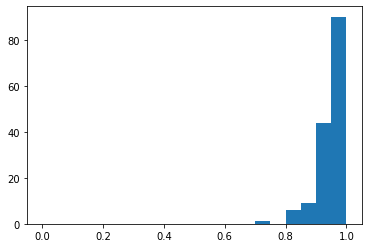

std: 0.044747, mean: 0.947875



<START> many animation buffs consider wladyslaw starewicz <START> great forgotten genius of one special branch of <START> art puppet animation which he invented almost single handedly <UNK> as it happened almost accidentally as a young man starewicz was more interested in entomology than <START> cinema but his unsuccessful attempt to film two stag beetles fighting led to an unexpected breakthrough in film making when he realized he could simulate movement by manipulating beetle carcasses <UNK> photographing them one frame at a time this discovery led to <START> production of amazingly elaborate classic short <START> cameraman's revenge which he made in russia in 1912 at a time when motion picture animation of all sorts was in its infancy br br <START> political tumult of <START> russian revolution caused starewicz to move to paris where one of his first productions coincidentally was a dark political satire variously known as frogland or <START> frogs w

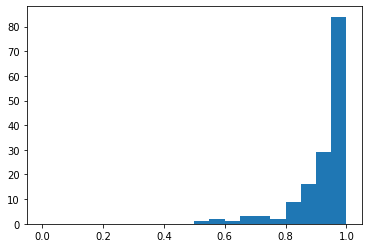

std: 0.091323, mean: 0.923926



<START> i generally love this type of movie however this time i found myself wanting to kick <START> screen since i can't do that i will just complain about it this was absolutely idiotic <START> things that happen with <START> dead kids are very cool but <START> alive people are absolute idiots i am a grown man pretty big <UNK> i can defend myself well however i would not do half <START> stuff <START> little girl does in this movie also <START> mother in this movie is reckless with her children to <START> point of neglect i wish i wasn't so angry about her <UNK> her actions because i would have otherwise enjoyed <START> flick what a number she was take my advise <UNK> fast forward through everything you see her do until <START> end also is anyone else getting sick of watching movies that are filmed so dark anymore one can hardly see what is being filmed as an audience we are impossibly involved with <START> actions on <START> screen so then why <START>

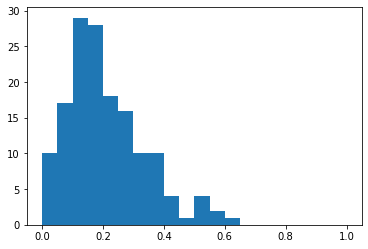

std: 0.128350, mean: 0.209594



<START> like some other people wrote i'm a die hard mario fan <UNK> i loved this game br br this game starts slightly boring but trust me it's worth it as soon as you start your hooked <START> levels are fun <UNK> exiting they will hook you 'till your mind turns to mush i'm not kidding this game is also orchestrated <UNK> is beautifully done br br to keep this spoiler free i have to keep my mouth shut about details but please try this game it'll be worth it br br story 9 9 action 10 1 it's that good hardness 10 attention grabber 10 average 10


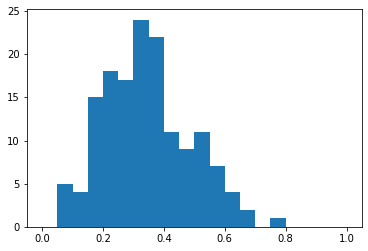

std: 0.141914, mean: 0.344655





In [50]:
# test data
for n in range(5):
    print(word_index.vec2sentence(x_test[n]))
    sample_model(x=x_test_padded[n])
    print("\n\n")

<START> this film was just brilliant casting location scenery story direction everyone's really suited <START> part they played <UNK> you could just imagine being there robert redford's is an amazing actor <UNK> now <START> same being director norman's father came from <START> same scottish island as myself so i loved <START> fact there was a real connection with this film <START> witty remarks throughout <START> film were great it was just brilliant so much that i bought <START> film as soon as it was released for retail <UNK> would recommend it to everyone to watch <UNK> <START> fly fishing was amazing really cried at <START> end it was so sad <UNK> you know what they say if you cry at a film it must have been good <UNK> this definitely was also congratulations to <START> two little boy's that played <START> part's of norman <UNK> paul they were just brilliant children are often left out of <START> praising list i think because <START> stars that play them all grown up are such a big

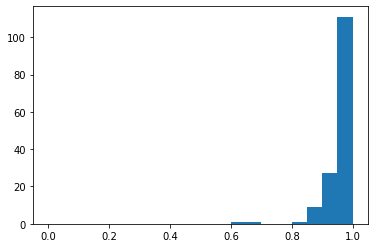

std: 0.048218, mean: 0.957743



<START> big hair big boobs bad music <UNK> a giant safety pin these are <START> words to best describe this terrible movie i love cheesy horror movies <UNK> i've seen hundreds but this had got to be on of <START> worst ever made <START> plot is paper thin <UNK> ridiculous <START> acting is an abomination <START> script is completely laughable <START> best is <START> end showdown with <START> cop <UNK> how he worked out who <START> killer is it's just so damn terribly written <START> clothes are sickening <UNK> funny in equal measures <START> hair is big lots of boobs bounce men wear those cut tee shirts that show off their stomachs sickening that men actually wore them <UNK> <START> music is just synthesiser trash that plays over <UNK> over again in almost every scene there is trashy music boobs <UNK> paramedics taking away bodies <UNK> <START> gym still doesn't close for bereavement all joking aside this is a truly bad film whose only charm is to look 

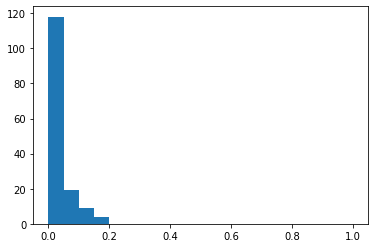

std: 0.039112, mean: 0.035658



<START> this has to be one of <START> worst films of <START> 1990s when my friends i were watching this film being <START> target audience it was aimed at we just sat watched <START> first half an hour with our jaws touching <START> floor at how bad it really was <START> rest of <START> time everyone else in <START> theatre just started talking to each other leaving or generally crying into their popcorn that they actually paid money they had earnt working to watch this feeble excuse for a film it must have looked like a great idea on paper but on film it looks like no one in <START> film has a clue what is going on crap acting crap costumes i can't get across how embarrasing this is to watch save yourself an hour a bit of your life


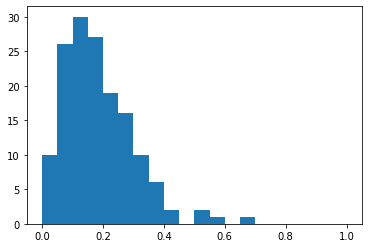

std: 0.115635, mean: 0.186252



<START> <START> scots excel at storytelling <START> traditional sort many years after <START> event i can still see in my mind's eye an elderly lady my friend's mother retelling <START> battle of culloden she makes <START> characters come alive her passion is that of an eye witness one to <START> events on <START> sodden heath a mile or so from where she lives br br of course it happened many years before she was born but you wouldn't guess from <START> way she tells it <START> same story is told in bars <START> length <UNK> breadth of scotland as i discussed it with a friend one night in mallaig a local cut in to give his version <START> discussion continued to closing time br br stories passed down like this become part of our being who doesn't remember <START> stories our parents told us when we were children they become our invisible world <UNK> as we grow older they maybe still serve as inspiration or as an emotional reservoir fact <UNK> fiction bl

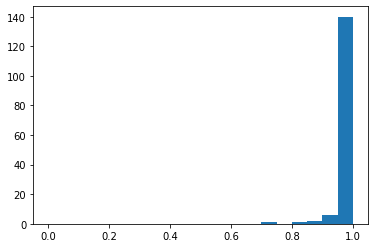

std: 0.030468, mean: 0.980859



<START> worst mistake of my life br br i picked this movie up at target for 5 because i figured hey it's sandler i can get some cheap laughs i was wrong completely wrong mid way through <START> film all three of my friends were asleep <UNK> i was still suffering worst plot worst script worst movie i have ever seen i wanted to hit my head up against a wall for an hour then i'd stop <UNK> you know why because it felt damn good upon bashing my head in i stuck that damn movie in <START> microwave <UNK> watched it burn <UNK> that felt better than anything else i've ever done it took american psycho army of darkness <UNK> kill bill just to get over that crap i hate you sandler for actually going through with this <UNK> ruining a whole day of my life


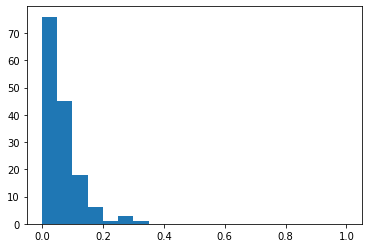

std: 0.058584, mean: 0.064964





In [ ]:
# training data
for n in range(5):
    print(word_index.vec2sentence(x_train[n]))
    sample_model(x=x_train_padded[n])
    print("\n\n")

1/1 [==============================] - 0s 15ms/sample


(array([30., 31., 35., 11.,  9., 14., 51., 35., 24., 10.]),
 array([0.00490576, 0.09534185, 0.18577794, 0.27621403, 0.36665012,
        0.45708621, 0.54752229, 0.63795838, 0.72839447, 0.81883056,
        0.90926665]),
 <a list of 10 Patch objects>)

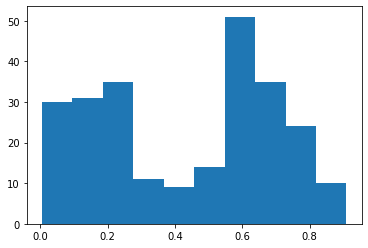

In [102]:
mean_y_train = np.mean(y_train)
std_y_train = np.std(y_train)

def predict(X_test, y_test):
    """
        Function for making predictions with the Bayesian neural network.
        @param X_test   The tensor of features for the test data
        @param y_test   The tensor of labels for the test data
    """
        
    X_test = np.array(X_test, ndmin = 2)
    y_test = np.array(y_test, ndmin = 2).T

    # We compute the predictive mean and variance for the target variables
    # of the test data

    standard_pred = model.predict(X_test, batch_size=500, verbose=1)
    standard_pred = standard_pred * std_y_train + mean_y_train
    rmse_standard_pred = np.mean((y_test.squeeze() - standard_pred.squeeze())**2.)**0.5

    Yt_hat = np.array([model.predict(X_test, batch_size=500, verbose=0) for _ in range(T)])
    Yt_hat = Yt_hat * std_y_train + mean_y_train
    MC_pred = np.mean(Yt_hat, 0)
    rmse = np.mean((y_test.squeeze() - MC_pred.squeeze())**2.)**0.5
    
    # We compute the test log-likelihood
    log_likelihood = (tf.reduce_logsumexp(-0.5 * tau * (y_test[None] - Yt_hat)**2., 0) - np.log(T) 
        - 0.5*np.log(2*np.pi) + 0.5*np.log(tau))
    test_ll = np.mean(log_likelihood)

    return rmse_standard_pred, rmse, test_ll

rmses = []
for i in range(250):
    rmse_standard_pred, rmse, test_ll = predict(x_test_padded[i:i+1], y_test[i:i+1])
    rmses += [rmse]

plt.hist(rmses)